In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# force GPU device
os.environ["CUDA_VISIBLE_DEVICES"]='0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.models import load_model
from keras import Sequential, Input

from sklearn.metrics import classification_report

2024-06-25 10:20:08.704647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
checkpoint_path = 'saves/rnn/200'
model_path = f'{checkpoint_path}/model.keras'
log_path = f'{checkpoint_path}/log.csv'
history_path = f'{checkpoint_path}/history.npy'

# ensure directory exists
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

load data from csv

In [3]:
max_sequence_length = 200

In [4]:
data_directory = '/home/jrosendahl/datasets/cadets/sequences/'

data = []

labels = None
no_labels = None

distinct_features = [
'EVENT_ACCEPT', 'EVENT_BIND', 'EVENT_CHANGE_PRINCIPAL', 'EVENT_CLOSE', 'EVENT_CONNECT', 'EVENT_CREATE_OBJECT', 'EVENT_EXECUTE', 'EVENT_EXIT', 'EVENT_FCNTL', 'EVENT_FORK', 'EVENT_LINK', 'EVENT_LOGIN', 'EVENT_LSEEK', 'EVENT_MMAP', 'EVENT_MODIFY_FILE_ATTRIBUTES', 'EVENT_MODIFY_PROCESS', 'EVENT_MPROTECT', 'EVENT_OPEN', 'EVENT_OTHER', 'EVENT_READ', 'EVENT_RECVFROM', 'EVENT_RECVMSG', 'EVENT_RENAME', 'EVENT_SENDMSG', 'EVENT_SENDTO', 'EVENT_SIGNAL', 'EVENT_TRUNCATE', 'EVENT_UNLINK', 'EVENT_WRITE', 
]
distinct_features = [ x[6:] for x in distinct_features ]
no_features = len(distinct_features)

count = 0
count_long_sequences_splitted = 0
count_long_sequences_splitted_result = 0
for file_name in os.listdir(data_directory):
    count += 1
    if count % 50000 == 0:
        print(f'Loaded {count} sequences')
    with open(data_directory + file_name, 'r') as f:
        label = file_name.split('_')[0]
        # build dictionary with counts of events
        lines = f.readlines()
        # if sequence is longer than max_sequence_length, split into multiple sequences
        if len(lines) > max_sequence_length:
            count_long_sequences_splitted += 1
            for i in range(0, len(lines), max_sequence_length):
                count_long_sequences_splitted_result += 1
                datapoints = []
                for event in lines[i:i+max_sequence_length]:
                    event = event.strip()
                    datapoints.append(distinct_features.index(event))
                data.append((label, datapoints))
        else:
            datapoints = []
            for event in lines:
                event = event.strip()
                datapoints.append(distinct_features.index(event))
            data.append((label, datapoints))

        """
        datapoints = []
        for event in f:
            event = event.strip()
            datapoints.append(distinct_features.index(event))
        if not len(datapoints) > max_sequence_length:
            data.append((label, datapoints))
        """

print(f'Loaded {len(data)} sequences')
print(f'Found {count_long_sequences_splitted} sequences longer than max_sequence_length ({max_sequence_length})')
print(f'Split them into {count_long_sequences_splitted_result} sequences')

print(f'Filtered out datapoints with less than 10 occurrences')
print(f'Left with {len(data)} datapoints')

random.shuffle(data)
labels = [ x[0] for x in data ]
data = [ x[1] for x in data ]

Loaded 50000 sequences
Loaded 100000 sequences
Loaded 150000 sequences
Loaded 200000 sequences
Loaded 250000 sequences
Loaded 300000 sequences
Loaded 350000 sequences
Loaded 400000 sequences
Loaded 581527 sequences
Found 31324 sequences longer than max_sequence_length (200)
Split them into 181988 sequences
Filtered out datapoints with less than 10 occurrences
Left with 581527 datapoints


In [6]:
distinct_labels = np.unique(np.array(labels))
no_labels = len(distinct_labels)
print(f'Found {no_labels} distinct labels')

# get distinct features
print(f'Found {no_features} distinct features')

# encode labels from strings to integers to one-hot
# labels = np.eye(no_labels)[np.vectorize(distinct_labels.tolist().index)(labels)]
# encode labels to integers
labels = np.vectorize(distinct_labels.tolist().index)(labels)
print(f'Encoded labels to integers')
# encode labels to one-hot
labels = np.eye(no_labels)[labels]
print(f'Encoded labels to one-hot')

# encode sequences from list of integers to list of one-hot
data = [ np.eye(no_features)[x] for x in data ]
print(f'Encoded sequences to one-hot')

# get pad event to pad sequences with when batches are built
pad_event = np.zeros(no_features)

Found 135 distinct labels
Found 29 distinct features
Encoded labels to integers
Encoded labels to one-hot
Encoded sequences to one-hot


In [7]:
print(f'data length: {len(data)}')
print(f'labels shape: {labels.shape}')

data length: 581527
labels shape: (581527, 135)


prepare data + generator

In [8]:
# split data into training and validation
split = int(len(data) * 0.8)

X_train = data[:split]
y_train = np.array(labels[:split])

X_val = data[split:]
y_val = np.array(labels[split:])

print(f'Training on {len(X_train)} samples')
print(f'Validating on {len(X_val)} samples')

Training on 465221 samples
Validating on 116306 samples


In [9]:
class Generator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size, fixed_length, **kwargs):
        # valid **kwargs: workers, use_multiprocessing, max_queue_size
        super().__init__()
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.fixed_length = fixed_length
        self.no_samples = len(X)
        self.no_batches = int(np.ceil(self.no_samples / self.batch_size))

    def __len__(self):
        return self.no_batches

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, self.no_samples)

        # Get the batch data
        X_batch = self.X[start:end]
        y_batch = self.y[start:end]

        # Pad or truncate each sequence in X_batch to the fixed length
        X_batch_fixed = [self._pad_or_truncate(x, self.fixed_length) for x in X_batch]

        # Convert to numpy arrays
        X_batch_fixed = np.array(X_batch_fixed)
        y_batch = np.array(y_batch)

        return X_batch_fixed, y_batch

    def _pad_or_truncate(self, sequence, length):
        if len(sequence) < length:
            # Pad sequence with zeros to the fixed length
            return np.pad(sequence, ((0, length - len(sequence)), (0, 0)), mode='constant', constant_values=0)
        else:
            # Truncate sequence to the fixed length
            return sequence[:length]

    def on_epoch_end(self):
        pass

build model

In [20]:
model = Sequential(layers=[
    Input(shape=(None, no_features)),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(64, return_sequences=False),
    Dense(no_labels, activation='softmax')
])

model.summary()

2024-06-24 15:25:07.212284: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9798 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 64)       │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 135)            │         8,775 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,303 (122.28 KB)

 Trainable params: 31,303 (122.28 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto'
)

model_checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_schedule = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-7
)

csv_logger = CSVLogger(
    filename=log_path,
    append=True
)

optimizer = Adam(learning_rate=0.0001)


# 'categorical_focal_crossentropy'
# 'categorical_crossentropy'
model.compile(optimizer=optimizer, loss='categorical_focal_crossentropy', metrics=['accuracy'])

train model

In [10]:
# load old model
model = load_model(model_path)

In [13]:
history = model.fit(
    x=Generator(X_train, y_train, 64, max_sequence_length),
    validation_data=Generator(X_val, y_val, 32, max_sequence_length),
    epochs=100,
    callbacks=[early_stop, model_checkpoint, lr_schedule, csv_logger],
)

# save history to file
with open(history_path, 'wb') as f:
    np.save(f, history.history)

Epoch 1/100


I0000 00:00:1718887169.559857  697200 service.cc:145] XLA service 0x11d53f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718887169.559916  697200 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-06-20 14:39:29.641166: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-20 14:39:29.915109: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


   2/7270 ━━━━━━━━━━━━━━━━━━━━ 6:32 54ms/step - accuracy: 0.0117 - loss: 1.2188 

I0000 00:00:1718887170.983121  697200 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7270/7270 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7895 - loss: 0.2351
Epoch 1: val_loss improved from inf to 0.04791, saving model to saves/rnn/200/model.keras
7270/7270 ━━━━━━━━━━━━━━━━━━━━ 449s 61ms/step - accuracy: 0.7895 - loss: 0.2351 - val_accuracy: 0.9102 - val_loss: 0.0479 - learning_rate: 1.0000e-04
Epoch 2/100
7270/7270 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9133 - loss: 0.0446
Epoch 2: val_loss improved from 0.04791 to 0.03545, saving model to saves/rnn/200/model.keras
7270/7270 ━━━━━━━━━━━━━━━━━━━━ 440s 61ms/step - accuracy: 0.9133 - loss: 0.0446 - val_accuracy: 0.9236 - val_loss: 0.0354 - learning_rate: 1.0000e-04
Epoch 3/100
7270/7270 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9258 - loss: 0.0326
Epoch 3: val_loss improved from 0.03545 to 0.02979, saving model to saves/rnn/200/model.keras
7270/7270 ━━━━━━━━━━━━━━━━━━━━ 439s 60ms/step - accuracy: 0.9258 - loss: 0.0326 - val_accuracy: 0.9296 - val_loss: 0.0298 - learning_rate: 1.0000e-04
Epoch 4/100
72

In [ ]:
# load history from file
history = np.load(history_path, allow_pickle=True).item()

In [ ]:
# plot history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

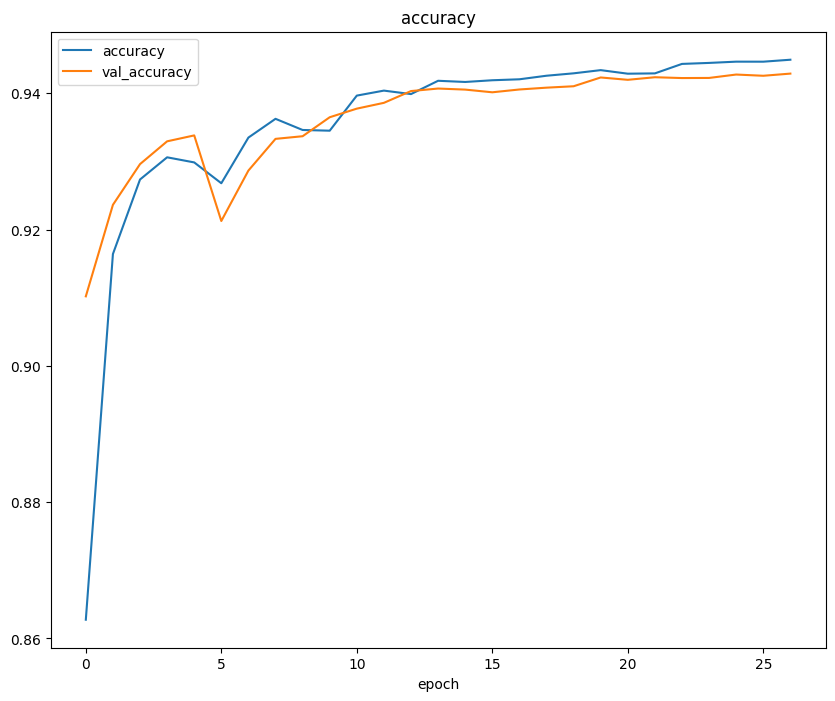

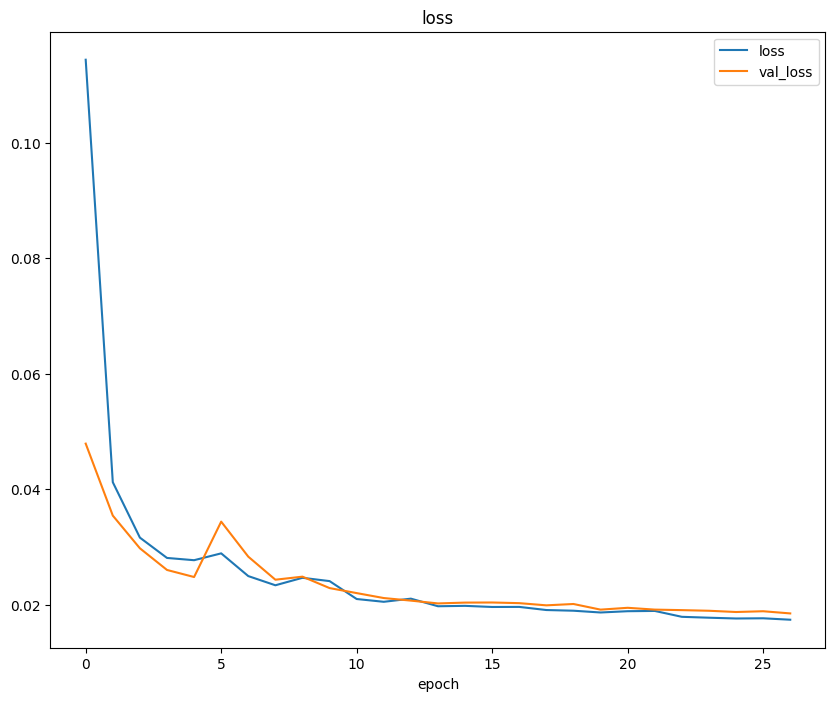

In [11]:
log = pd.read_csv(log_path)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(log['epoch'], log['accuracy'], label='accuracy')
ax.plot(log['epoch'], log['val_accuracy'], label='val_accuracy')
ax.set_title('accuracy')
ax.set_xlabel('epoch')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(log['epoch'], log['loss'], label='loss')
ax.plot(log['epoch'], log['val_loss'], label='val_loss')
ax.set_title('loss')
ax.set_xlabel('epoch')
ax.legend()

plt.show()

In [10]:
# load model from file
model = load_model(model_path)

In [12]:
# evaluate model
score = model.evaluate(x=Generator(X_val, y_val, 32, max_sequence_length))

I0000 00:00:1719303177.801986  756044 service.cc:145] XLA service 0x14d13bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719303177.802062  756044 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5


   6/3635 ━━━━━━━━━━━━━━━━━━━━ 1:31 25ms/step - accuracy: 0.9837 - loss: 0.0087

I0000 00:00:1719303178.354555  756044 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3635/3635 ━━━━━━━━━━━━━━━━━━━━ 84s 23ms/step - accuracy: 0.9457 - loss: 0.0170


In [13]:
# print classification report
# combine X_train and X_val

y_pred = model.predict(x=Generator(X_val, y_val, 32, max_sequence_length))
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred, target_names=distinct_labels, labels=np.arange(no_labels), zero_division=np.nan))

3635/3635 ━━━━━━━━━━━━━━━━━━━━ 88s 24ms/step
                 precision    recall  f1-score   support

            XIM        nan      0.00      0.00         1
      adjkerntz        nan      0.00      0.00        26
         alpine       0.81      0.58      0.67       685
          anvil       0.83      0.57      0.67       483
          atrun       1.00      1.00      1.00       622
            awk       1.00      0.92      0.96        12
       basename        nan      0.00      0.00         2
           bash       0.95      0.97      0.96     32272
         bounce        nan      0.00      0.00         1
          bzcat       0.00      0.00      0.00         7
          bzip2        nan      0.00      0.00         1
            cat       0.82      0.93      0.88        60
         chkgrp       0.67      1.00      0.80         2
          chmod        nan       nan       nan         0
          chown        nan       nan       nan         0
        cleanup       0.97      0.56      